## Setup and Preprocessing
### Import Required Packages

In [1]:
import glob
import numpy as np
import pandas as pd
import cv2 as cv
import os
import glob
import random
import seaborn as sns
from PIL import Image
from itertools import product


from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import torch

from transformers import AutoFeatureExtractor, AutoModelForImageClassification

from utils import *

In [2]:
classN_img_path = "Data/train/normal"
classA_img_path = "Data/train/adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib"
classL_img_path = "Data/train/large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa"
classS_img_path = "Data/train/squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa"

image_paths = {"normal": classN_img_path, 
               "adenocarcinoma": classA_img_path,
               "large_cell_carcinoma": classL_img_path, 
               "squamous_cell_carcinoma": classS_img_path}

train_and_valid_class_mappings = {
    0: "normal",
    1: "adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib",
    2: "large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa",
    3: "squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa"
}

test_class_mappings = {
    0: "normal",
    1: "adenocarcinoma",
    2: "large.cell.carcinoma",
    3: "squamous.cell.carcinoma"
}

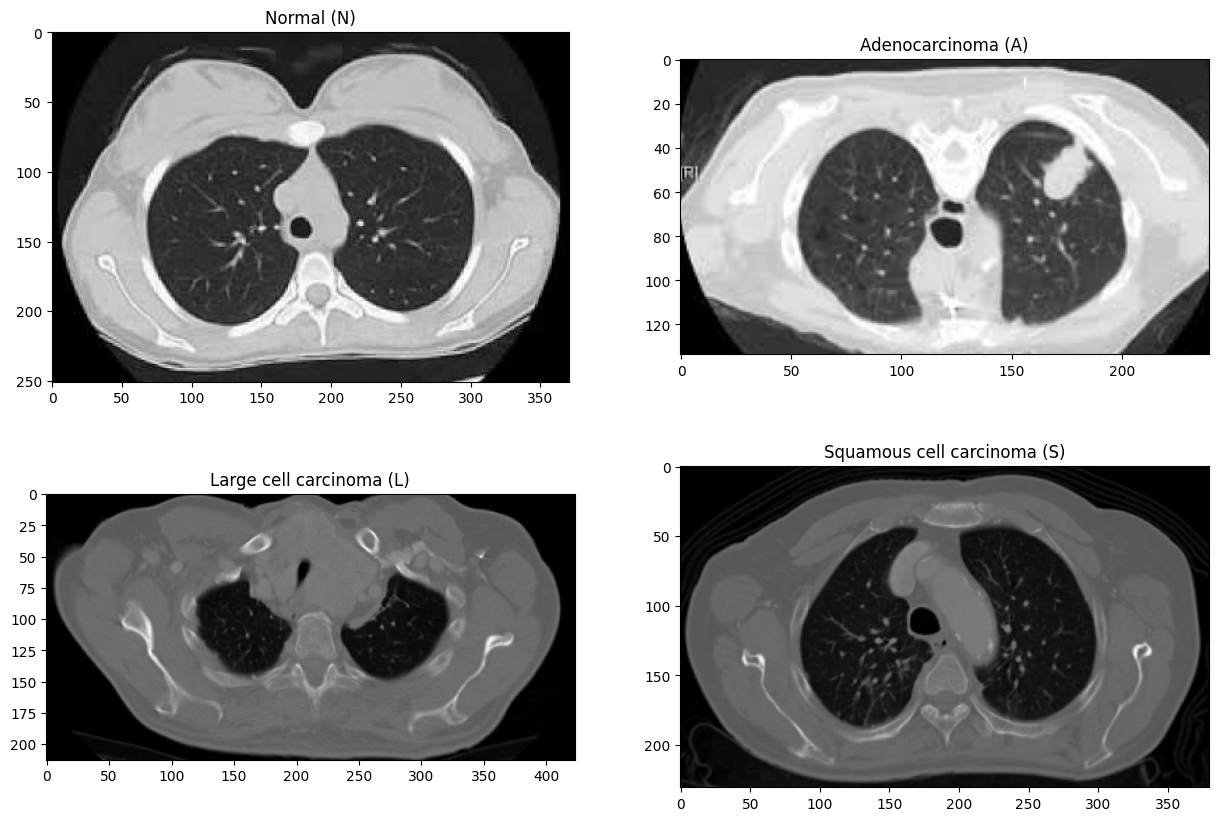

In [3]:
normal_example_path = classN_img_path + "/10.png"
adenocarcinoma_example_path = classA_img_path + "/ad4.png"
large_cell_carcinoma_example_path = classL_img_path + "/000002.png"
squamous_cell_carcinoma_example_path = classS_img_path + "/000003.png"

def plot_imgs(imN, imA, imL, imS):
    # display the points
    fig, ax = plt.subplots(figsize=(15, 10), nrows=2, ncols=2)
    ax[0][0].imshow(imN, cmap='gray')
    ax[0][0].set_title("Normal (N)")

    ax[0][1].imshow(imA, cmap='gray')
    ax[0][1].set_title("Adenocarcinoma (A)")

    ax[1][0].imshow(imL, cmap='gray')
    ax[1][0].set_title("Large cell carcinoma (L)")

    ax[1][1].imshow(imS, cmap='gray')
    ax[1][1].set_title("Squamous cell carcinoma (S)")
    plt.show()
    
imN = plt.imread(normal_example_path)
imA = plt.imread(adenocarcinoma_example_path)
imL = plt.imread(large_cell_carcinoma_example_path)
imS = plt.imread(squamous_cell_carcinoma_example_path)
plot_imgs(imN, imA, imL, imS)

In [4]:
crop_and_resize_images("Data/train", train_and_valid_class_mappings, (256,256), 'Data_cropped_and_resized')

In [5]:
crop_and_resize_images("Data/valid", train_and_valid_class_mappings, (256,256), 'Data_cropped_and_resized')

In [6]:
crop_and_resize_images("Data/test", test_class_mappings, (256,256), 'Data_cropped_and_resized')

## Histogram Equalization

In [7]:
equalize_images("Data_cropped_and_resized/train", train_and_valid_class_mappings, 'Data_cropped_resized_equalized')
equalize_images("Data_cropped_and_resized/valid", train_and_valid_class_mappings, 'Data_cropped_resized_equalized')
equalize_images("Data_cropped_and_resized/test", test_class_mappings, 'Data_cropped_resized_equalized')



In [8]:
from skimage import io
def plot_img_and_hist(image, axes, title, bins=256):
    """ 
    Plot an image along with its histogram and cumulative histogram
    """

    image = img_as_float(image)
    ax_img, ax_hist = axes
    ax_cdf = ax_hist.twinx()

    # Display image
    ax_img.imshow(image, cmap=plt.cm.gray, vmin=0, vmax=1)
    ax_img.set_axis_off()
    ax_img.set_title(title)

    # Display histogram
    ax_hist.hist(image.ravel(), bins=bins, histtype='step', color='black')
    ax_hist.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))
    ax_hist.set_xlabel('Pixel intensity')
    ax_hist.set_xlim(0, 1)
    ax_hist.set_yticks([])

    # Display cumulative distribution
    img_cdf, bins = exposure.cumulative_distribution(image, bins)
    ax_cdf.plot(bins, img_cdf, 'r')
    ax_cdf.set_yticks([])

    return ax_cdf
    

def display_images(orig, hist_eq):
    """
    Plot the original image and all three modified images
    along with their histograms
    """
    
    orig = io.imread(orig)
    hist_eq = io.imread(hist_eq)

    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))

    # plot original
    plot_img_and_hist(orig, axes[:, 0], title='Original Image')

    # set left y-axis label
    y_min, y_max = axes[1, 0].get_ylim()
    axes[1, 0].set_ylabel('Number of pixels')
    axes[1, 0].set_yticks(np.linspace(0, y_max, 5))

    # plot modifications
    ax_cdf = plot_img_and_hist(hist_eq, axes[:, 1], title='Histogram Equalization')

    # set right y-axis label
    ax_cdf.set_ylabel('Fraction of total intensity')
    ax_cdf.set_yticks(np.linspace(0, 1, 5))

    # prevent overlap of y-axis labels
    fig.tight_layout()
    plt.show()


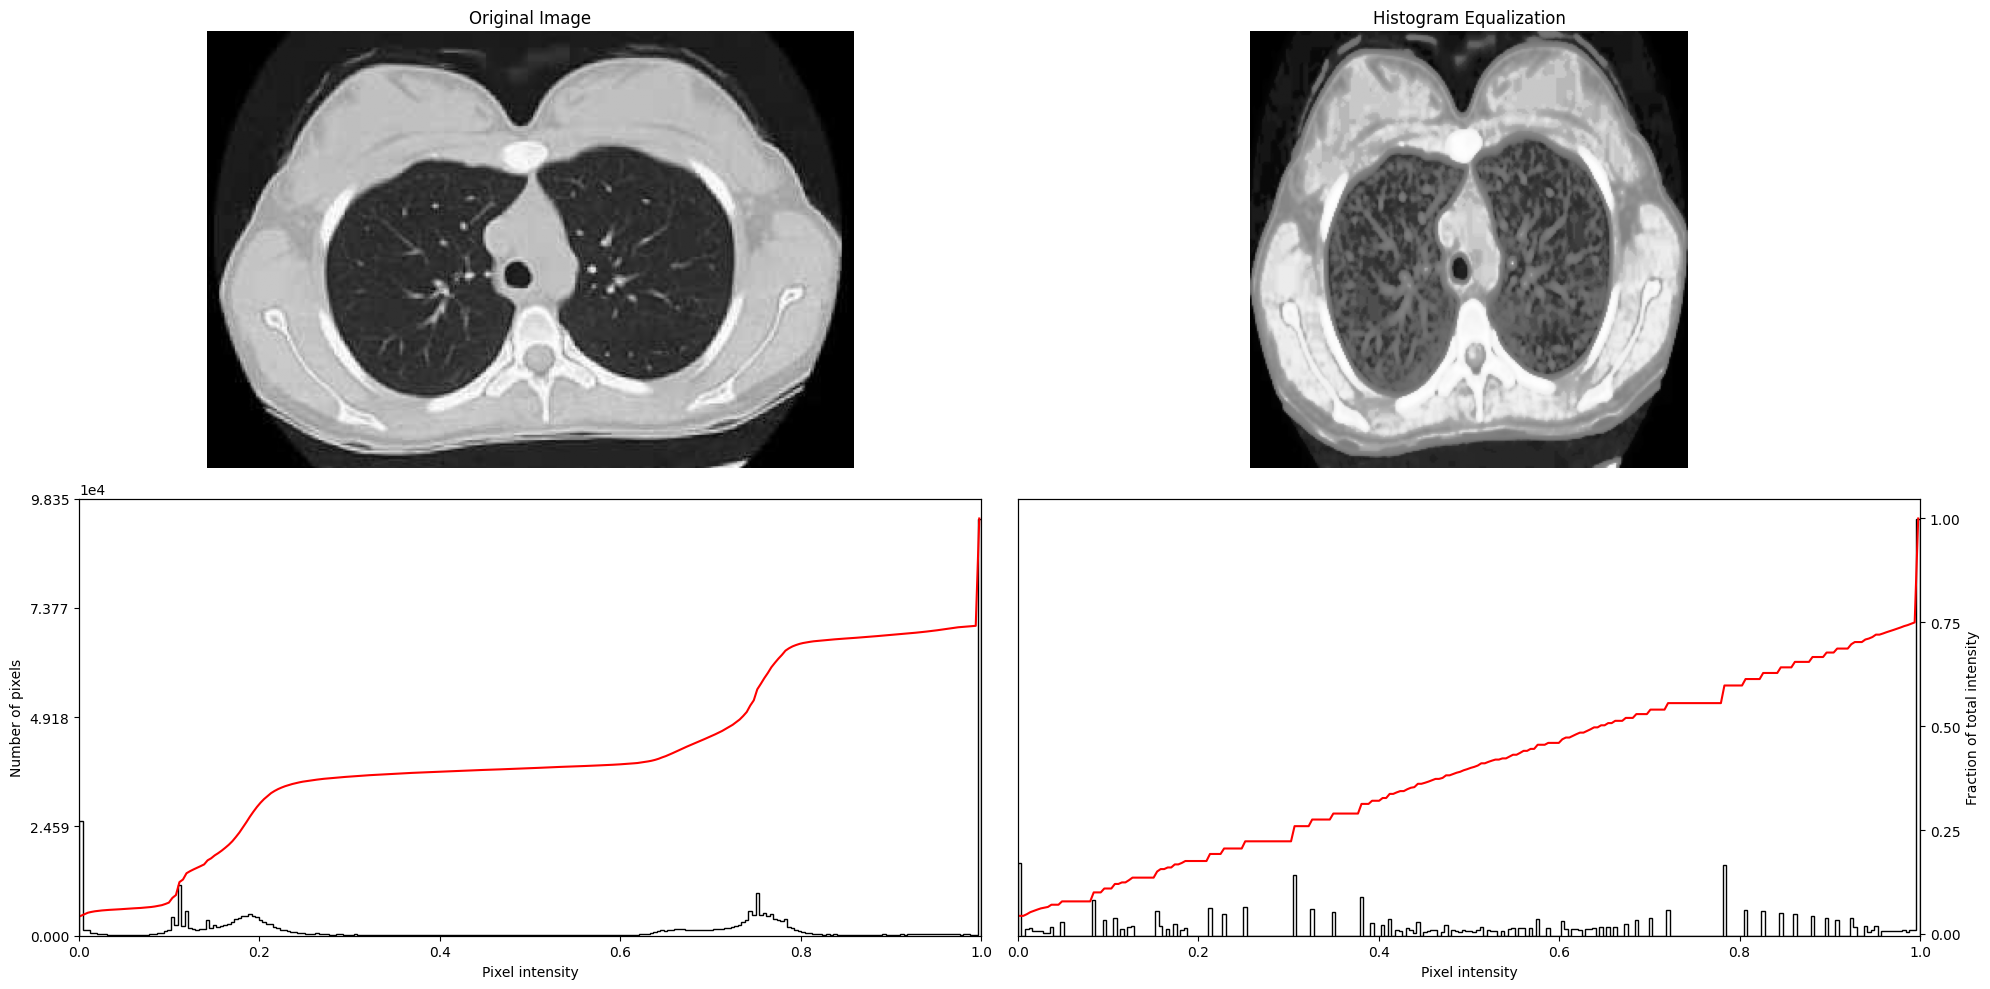

In [9]:
display_images("Data/train/normal/10.png","Data_cropped_resized_equalized/train/normal/10.png")


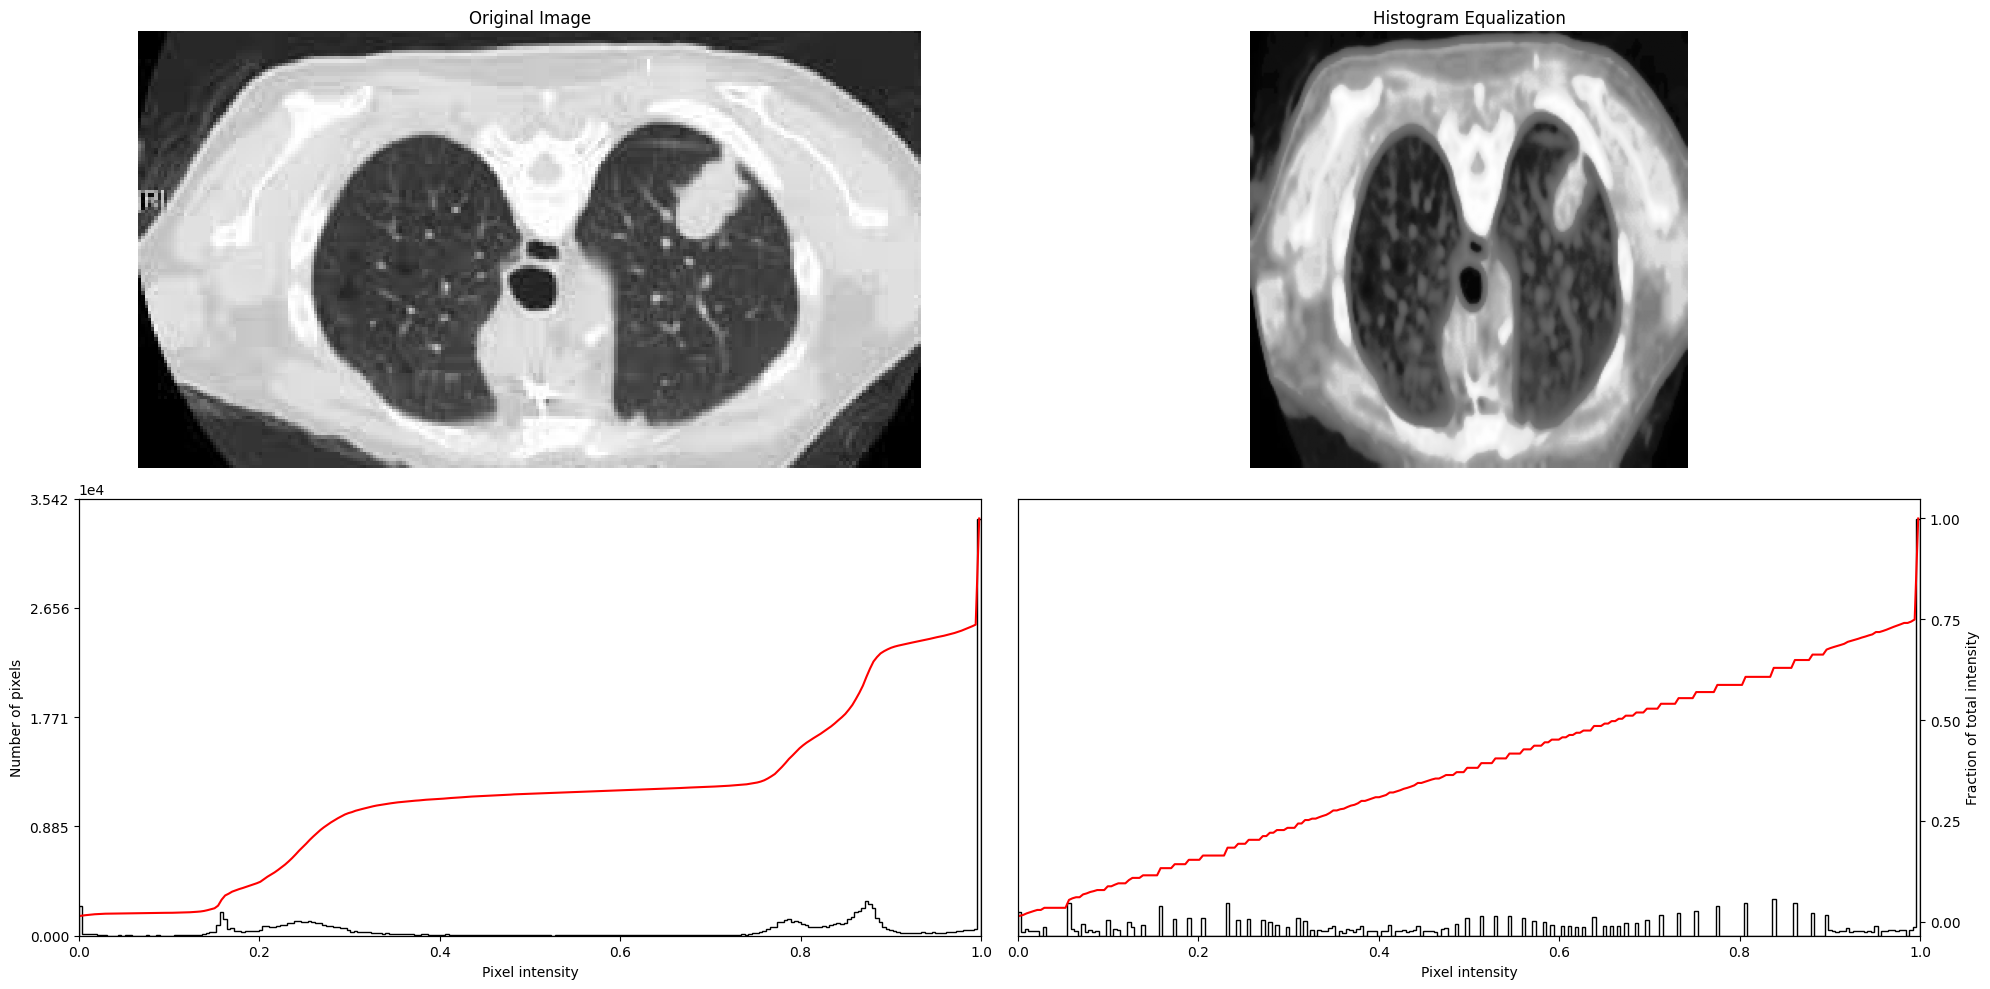

In [10]:
display_images("Data/train/adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib/ad4.png",
               "Data_cropped_resized_equalized/train/adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib/ad4.png")


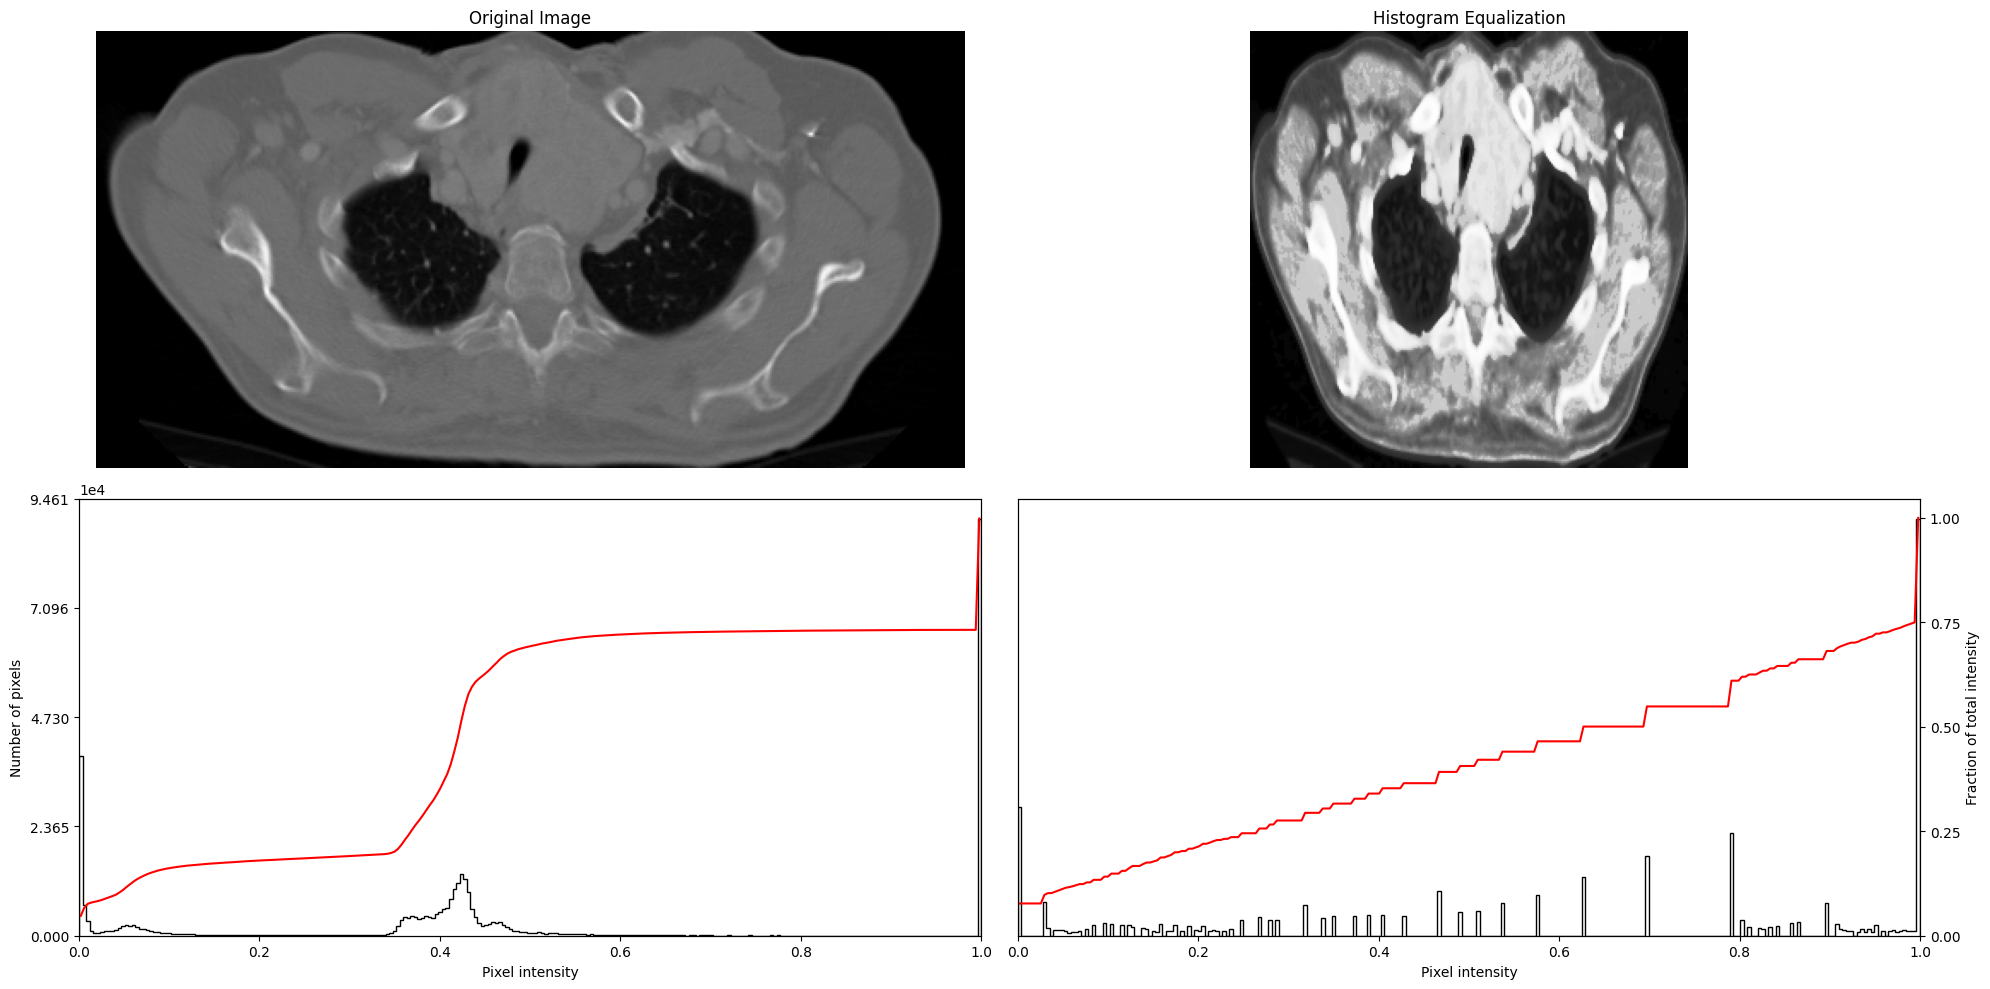

In [11]:
display_images("Data/train/large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa/000002.png",
               "Data_cropped_resized_equalized/train/large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa/000002.png")


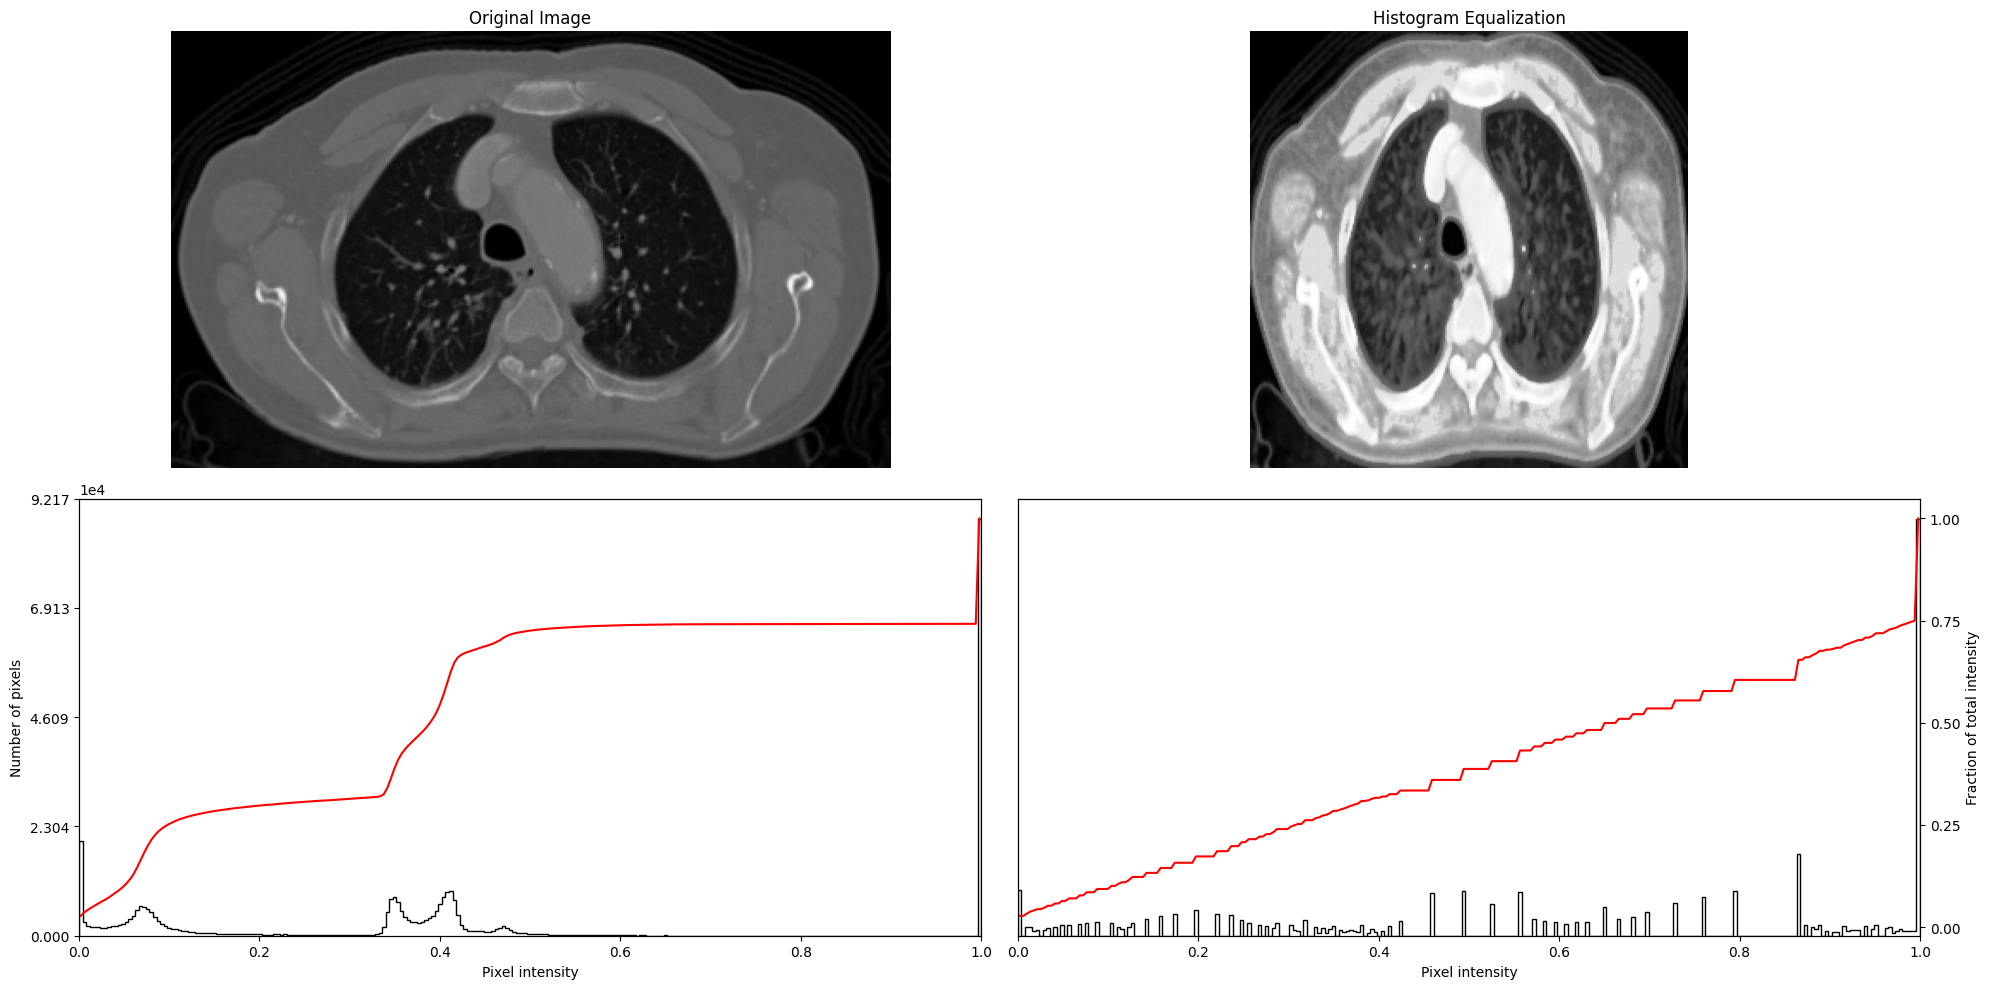

In [12]:
display_images("Data/train/squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa/000003.png",
               "Data_cropped_resized_equalized/train/squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa/000003.png")


## Feature Extraction

### Simple Feature Extraction

In [13]:
train_path = "Data_cropped_resized_equalized/train"
valid_path = "Data_cropped_resized_equalized/valid"


train_canny_edge_images, train_canny_edges, train_canny_labels = extract_features(train_path, 
                                           detect_canny_edges, 
                                           train_and_valid_class_mappings)

_, valid_canny_edges, valid_canny_labels = extract_features(valid_path, 
                                           detect_canny_edges, 
                                           train_and_valid_class_mappings)

train_sobel_edge_images, train_sobel_edges, train_sobel_labels = extract_features(train_path, 
                                                                                  detect_edges_sobel,
                                                                                  train_and_valid_class_mappings)

_, valid_sobel_edges, valid_sobel_labels = extract_features(valid_path,
                                                            detect_edges_sobel,
                                                            train_and_valid_class_mappings)

train_soft_tissue_images, train_soft_tissue, train_soft_tissue_labels = extract_features(train_path, get_soft_tissue, train_and_valid_class_mappings)
_, valid_soft_tissue, valid_soft_tissue_labels = extract_features(valid_path, get_soft_tissue, train_and_valid_class_mappings)



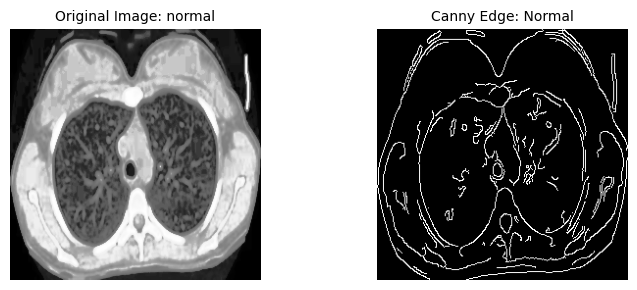

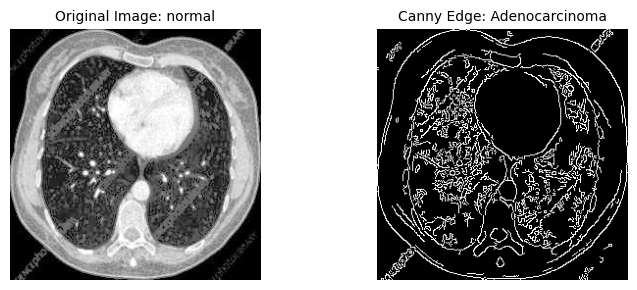

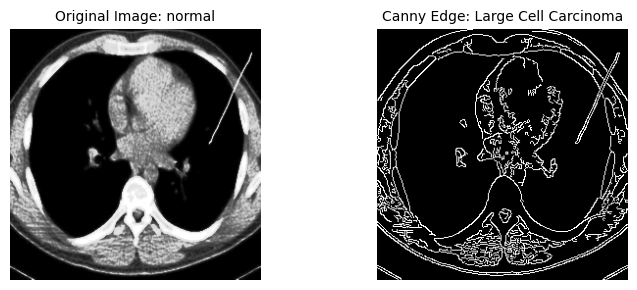

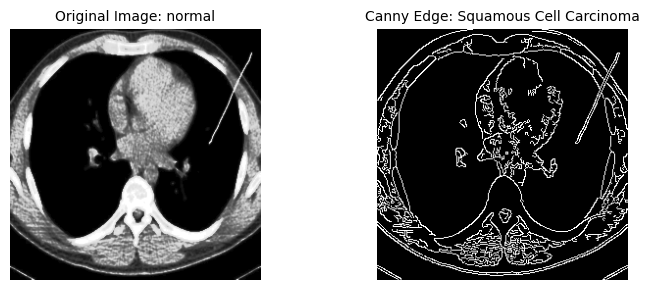

In [14]:
plot_features(train_canny_edge_images, 
              train_canny_edges, 
              train_canny_labels, 
              0, 
              'Canny Edge: Normal',
              test_class_mappings)
plot_features(train_canny_edge_images, 
              train_canny_edges, 
              train_canny_labels, 
              1, 
              'Canny Edge: Adenocarcinoma',
              test_class_mappings)
plot_features(train_canny_edge_images, 
              train_canny_edges, 
              train_canny_labels, 
              2, 
              'Canny Edge: Large Cell Carcinoma',
              test_class_mappings)
plot_features(train_canny_edge_images, 
              train_canny_edges, 
              train_canny_labels, 
              2, 
              'Canny Edge: Squamous Cell Carcinoma',
              test_class_mappings)


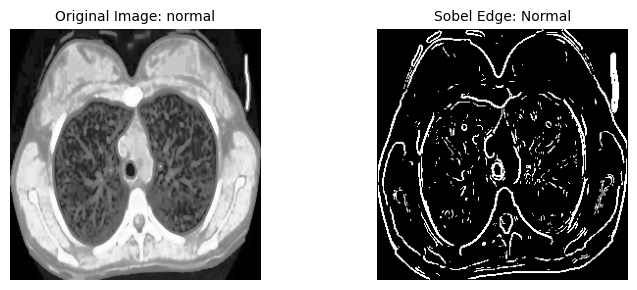

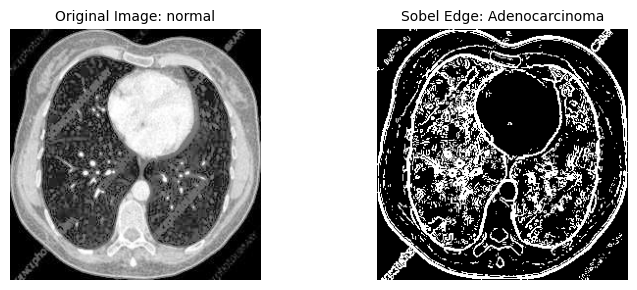

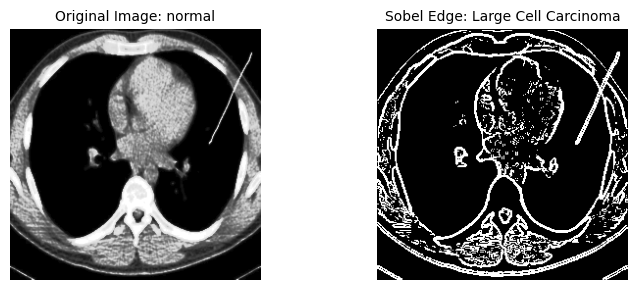

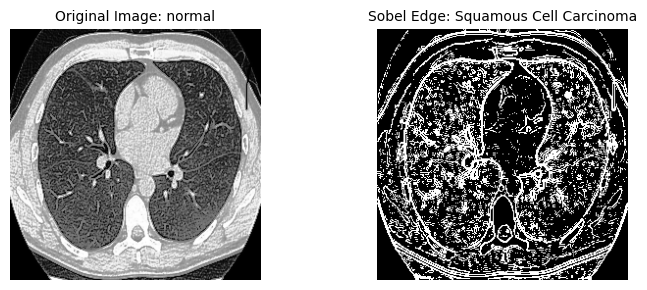

In [15]:
plot_features(train_sobel_edge_images, 
              train_sobel_edges, 
              train_sobel_labels, 
              0, 
              'Sobel Edge: Normal',
              test_class_mappings)
plot_features(train_sobel_edge_images, 
              train_sobel_edges, 
              train_sobel_labels, 
              1, 
              'Sobel Edge: Adenocarcinoma',
              test_class_mappings)
plot_features(train_sobel_edge_images, 
              train_sobel_edges, 
              train_sobel_labels, 
              2, 
              'Sobel Edge: Large Cell Carcinoma',
              test_class_mappings)
plot_features(train_sobel_edge_images, 
              train_sobel_edges, 
              train_sobel_labels, 
              3, 
              'Sobel Edge: Squamous Cell Carcinoma',
              test_class_mappings)


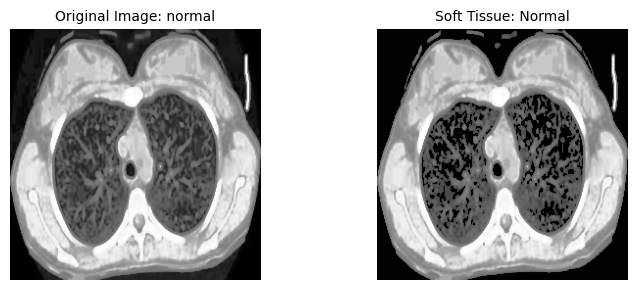

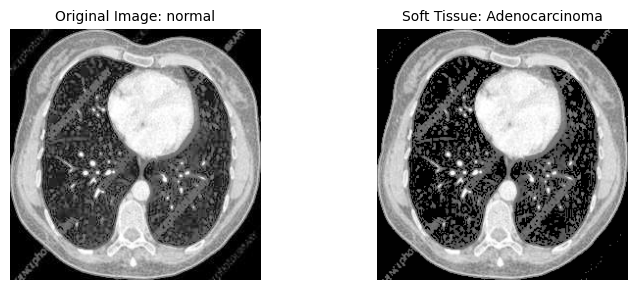

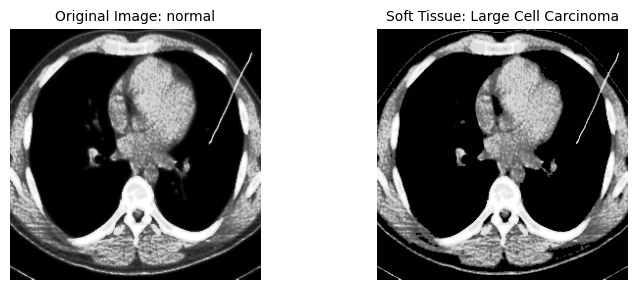

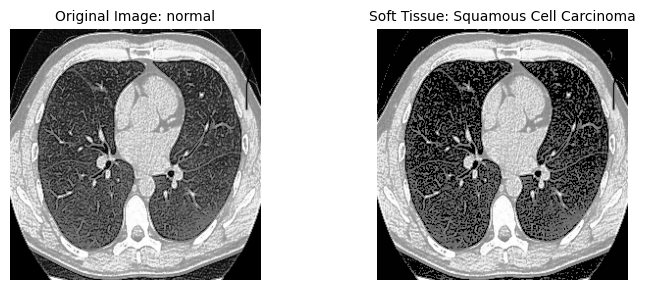

In [16]:
plot_features(train_soft_tissue_images, 
              train_soft_tissue, 
              train_soft_tissue_labels, 
              0, 
              'Soft Tissue: Normal',
              test_class_mappings)
plot_features(train_soft_tissue_images, 
              train_soft_tissue, 
              train_soft_tissue_labels, 
              1, 
              'Soft Tissue: Adenocarcinoma',
              test_class_mappings)
plot_features(train_soft_tissue_images, 
              train_soft_tissue, 
              train_soft_tissue_labels, 
              2, 
              'Soft Tissue: Large Cell Carcinoma',
              test_class_mappings)
plot_features(train_soft_tissue_images, 
              train_soft_tissue, 
              train_soft_tissue_labels, 
              3, 
              'Soft Tissue: Squamous Cell Carcinoma',
              test_class_mappings)

### Complex Feature Extraction using Neural Nets

In [17]:
extractor = AutoFeatureExtractor.from_pretrained("DunnBC22/vit-base-patch16-224-in21k_covid_19_ct_scans")
model = AutoModelForImageClassification.from_pretrained("DunnBC22/vit-base-patch16-224-in21k_covid_19_ct_scans")
model.eval()

/Users/zacharyzimmerman/Desktop/MIDS 281/mids-281-final-project/venv/lib/python3.9/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=7

In [18]:
def transformer_feature_vector(image, model=model, extractor=extractor):
    # Preprocess the image using the feature extractor
    image = Image.fromarray(image).convert('RGB')
    inputs = extractor(images=image, return_tensors="pt")
    # Forward pass through the model's transformer (without the classification head)
    with torch.no_grad():
        feature_vector = model.vit(**inputs).last_hidden_state
    # Optionally, convert to a NumPy array
    feature_vector = feature_vector.numpy()

    return feature_vector

In [19]:
train_transformer_images, train_transformer_features, train_transformer_labels = extract_features(train_path, 
                                                transformer_feature_vector, 
                                                train_and_valid_class_mappings)

valid_transformer_images, valid_transformer_features, valid_transformer_labels = extract_features(valid_path, 
                                                transformer_feature_vector, 
                                                train_and_valid_class_mappings)




## PCA Decomposition and tSNE visualization

In [20]:
def get_PCA(X_list, n_components=2):
    pca_list = []
    xpca_list = []
    for X in X_list:
        pca = PCA(n_components=n_components, svd_solver="randomized", whiten=True).fit(X)
        X_pca = pca.transform(X)
        pca_list.append(pca)
        xpca_list.append(X_pca)

    return pca_list, xpca_list

def plot_PCA(X_list, labels, n_components=2):
    pca_list, xpca_list = get_PCA(X_list, n_components=n_components)
    plt.figure(figsize=(15,5))
    colors = ['b-', 'm-', 'g-', 'r-']
    for i in range(len(X_list)):
        plt.plot(np.cumsum(pca_list[i].explained_variance_ratio_), colors[i], label=labels[i])
    plt.xticks(np.arange(n_components)+1)
    plt.yticks(np.linspace(0, 1, 8))
    
    # Get current x-ticks and labels
    locs, labels = plt.xticks()

    # Set new x-ticks and labels
    plt.xticks(locs[::10], labels[::10])
    plt.grid(True)
    plt.xlabel('Number of components')
    plt.ylabel('Explained Variances')
    plt.legend()
    plt.show()

def get_tsne(X_list, n_components=2):
    xtsne_list = []
    for X in X_list:
        tsne = TSNE(n_components=n_components, random_state=0)
        X_tsne = tsne.fit_transform(X)
        xtsne_list.append(X_tsne)
    return xtsne_list

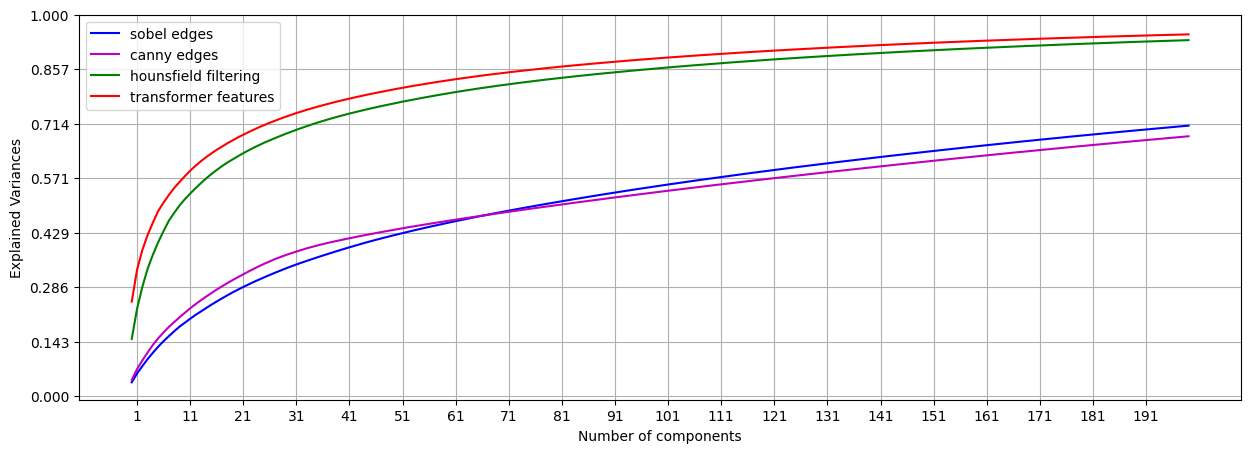

In [21]:
labels = ['sobel edges', 'canny edges', 'hounsfield filtering', 'transformer features']

training_features = [[img.flatten() for img in train_sobel_edges],
                    [img.flatten() for img in train_canny_edges],
                    [img.flatten() for img in train_soft_tissue],
                    [img.flatten() for img in train_transformer_features]]

plot_PCA(training_features, labels, n_components=200)

/Users/zacharyzimmerman/Desktop/MIDS 281/mids-281-final-project/venv/lib/python3.9/site-packages/threadpoolctl.py:1019: RuntimeWarning: libc not found. The ctypes module in Python 3.9 is maybe too old for this OS.
  warnings.warn(


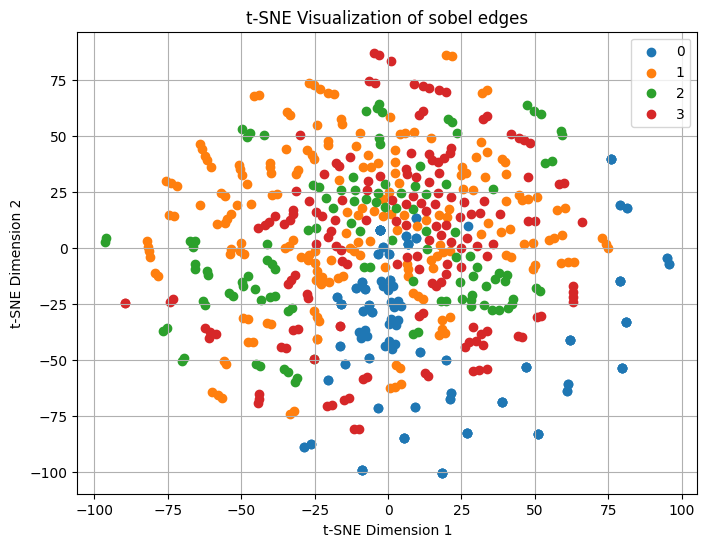

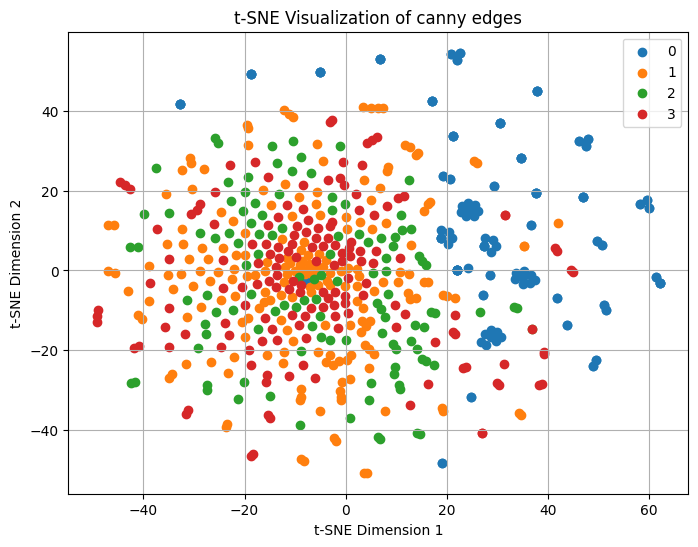

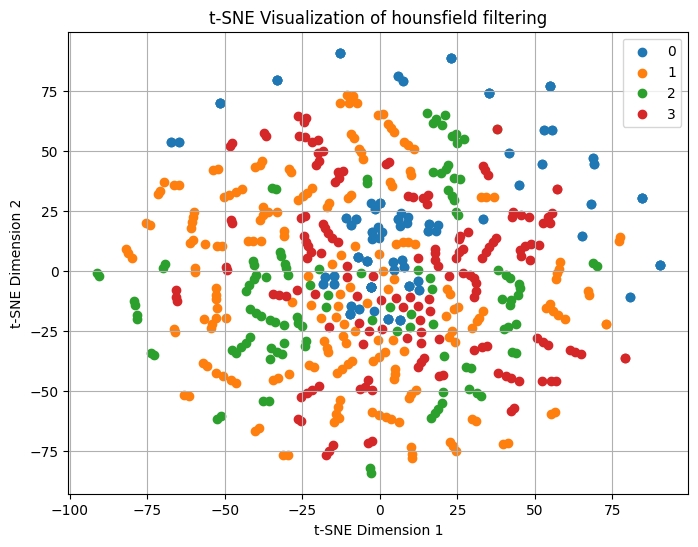

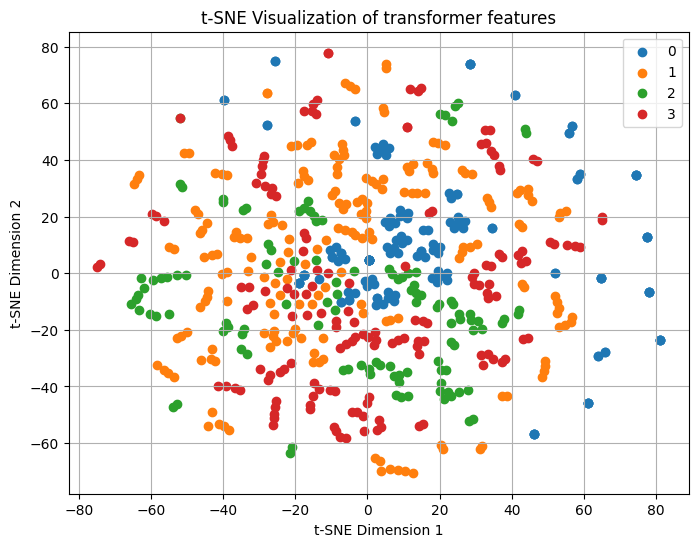

In [22]:
pca_list, xpca_list = get_PCA(training_features, n_components=200)

x_tsne_list = get_tsne(xpca_list)


for X_tsne, transform_type in zip(x_tsne_list, labels):

    plt.figure(figsize=(8, 6))

    for label in np.unique(train_sobel_labels):
        plt.scatter(X_tsne[train_sobel_labels == label, 0], X_tsne[train_sobel_labels == label, 1], label=label)

    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.title(f't-SNE Visualization of {transform_type}')
    plt.legend()
    plt.grid(True)
    plt.show()

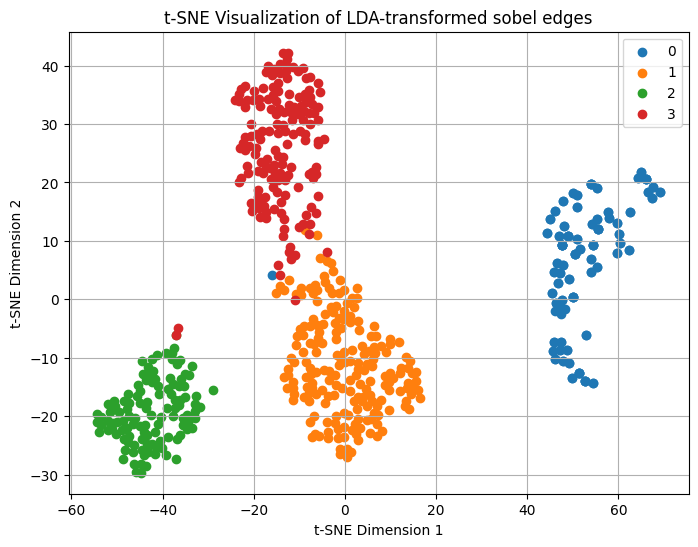

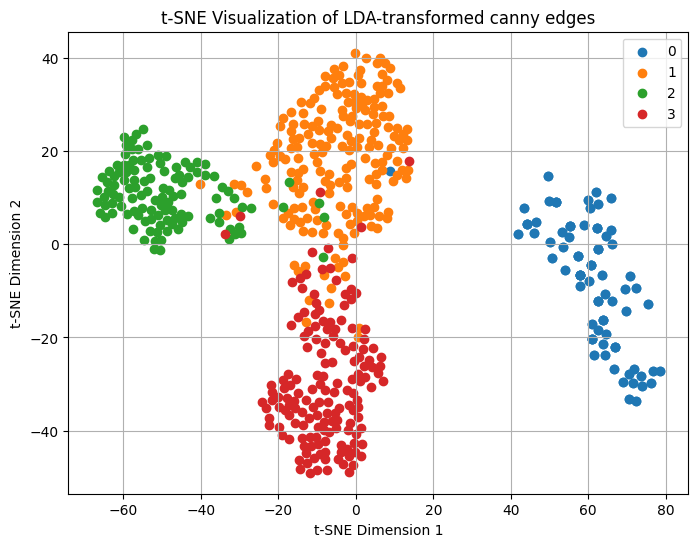

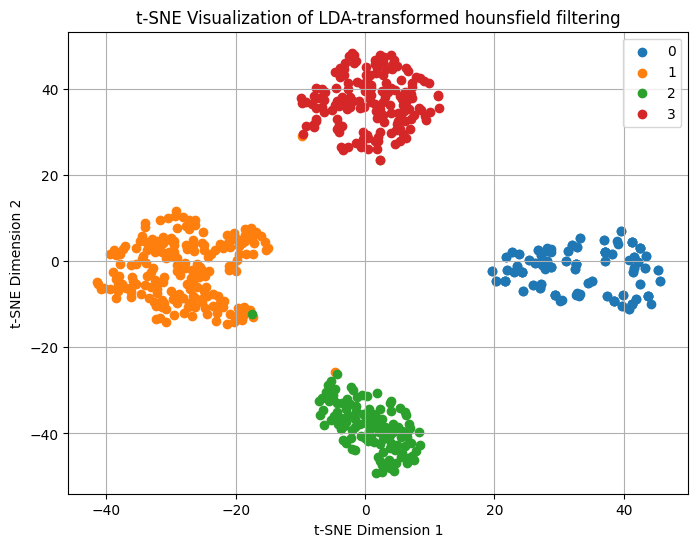

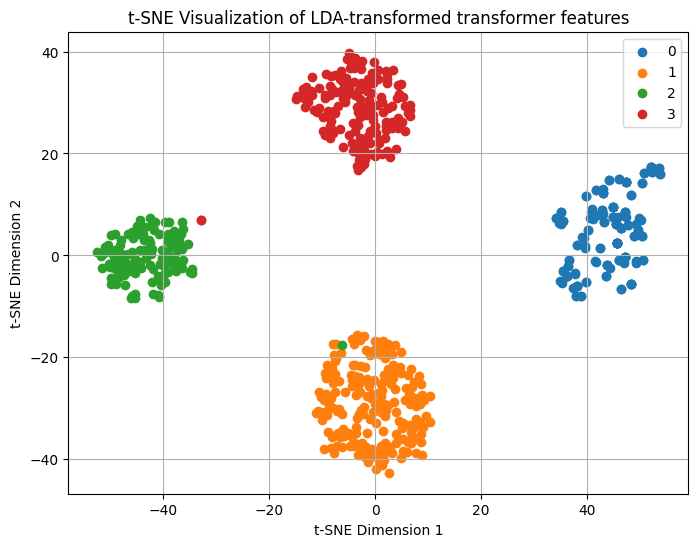

In [23]:
lda = LinearDiscriminantAnalysis()

for X_pca, transform_type in zip(xpca_list, labels):
    lda.fit(X_pca, train_sobel_labels)

    X_lda = lda.transform(X_pca)
    tsne = TSNE(n_components=2, random_state=42)
    X_tsne = tsne.fit_transform(X_lda)

    plt.figure(figsize=(8, 6))

    for label in np.unique(train_sobel_labels):
        plt.scatter(X_tsne[train_sobel_labels == label, 0], X_tsne[train_sobel_labels == label, 1], label=label)

    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.title(f't-SNE Visualization of LDA-transformed {transform_type}')
    plt.legend()
    plt.grid(True)
    plt.show()

## Building Classifiers

In [24]:
test_path = "Data_cropped_resized_equalized/test"

_, test_sobel_features, test_sobel_labels = extract_features(test_path, detect_edges_sobel, test_class_mappings)

_, test_canny_features, test_canny_labels = extract_features(test_path, detect_canny_edges, test_class_mappings)

_, test_soft_tissue, test_soft_tissue_labels = extract_features(test_path, get_soft_tissue, test_class_mappings)

_, test_transformer_features, test_transformer_labels = extract_features(test_path, 
                                                transformer_feature_vector, 
                                                test_class_mappings)

### Evaluate Classifiers Using Sobel Edges

In [25]:
pca_models, train_features_pca = get_PCA([[img.flatten() for img in train_sobel_edges]], n_components=200)

lda = LinearDiscriminantAnalysis()

lda.fit(train_features_pca[0], train_sobel_labels)

X_lda = lda.transform(train_features_pca[0])

X_lda.shape

(614, 3)

In [26]:
X_train = X_lda
y_train = train_sobel_labels

In [27]:
X_val_raw = np.array([img.flatten() for img in valid_sobel_edges])
X_val_pca = pca_models[0].transform(X_val_raw)
X_val = lda.transform(X_val_pca)


y_val = valid_sobel_labels

print(f"{X_val.shape=}")
print(f"{len(y_val)=}")

X_val.shape=(72, 3)
len(y_val)=72


In [28]:
X_test_raw = np.array([img.flatten() for img in test_sobel_features])
X_test_pca = pca_models[0].transform(X_test_raw)
X_test = lda.transform(X_test_pca)


y_test = test_sobel_labels

print(f"{X_test.shape=}")
print(f"{len(y_test)=}")

X_test.shape=(315, 3)
len(y_test)=315


In [29]:
param_grid = {
    'C': [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30, 100],
    'kernel': ['rbf', 'linear', 'sigmoid'],
    'gamma': [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30, 100]
}

svm_model = SVC()

grid_search = GridSearchCV(svm_model, param_grid, cv=5, scoring='f1_weighted')
# Fit the grid search to the data
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_svm = grid_search.best_estimator_

In [30]:
print("Best Hyperparameters:", best_params)

y_pred = best_svm.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
print("Best Model Accuracy:", accuracy)

Best Hyperparameters: {'C': 10, 'gamma': 0.01, 'kernel': 'linear'}
Best Model Accuracy: 0.7638888888888888


In [31]:
svm_predictions = best_svm.predict(X_test)
conf_matrix = confusion_matrix(y_test, svm_predictions)

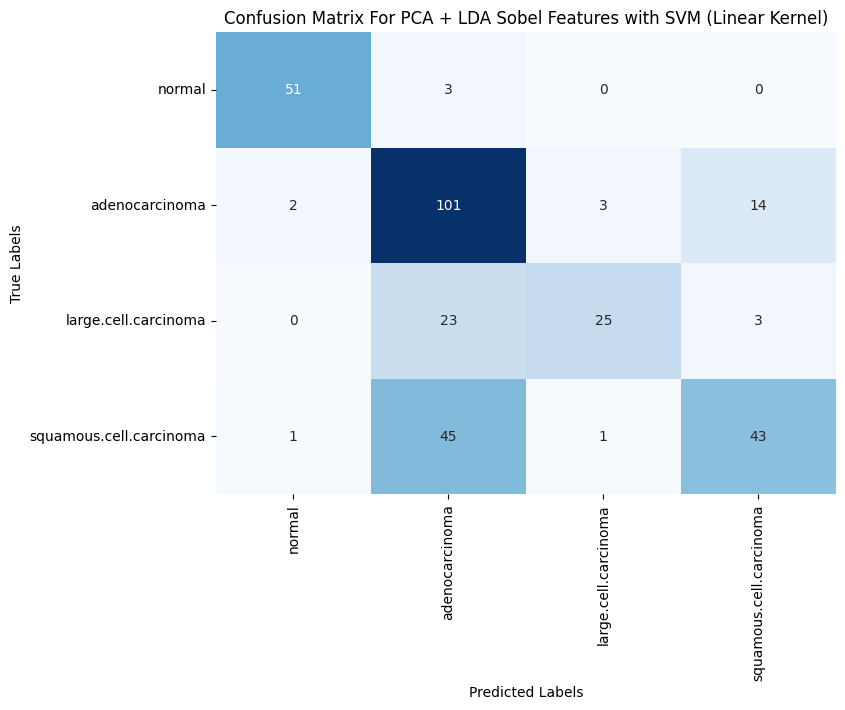

Classification Report:
                          precision    recall  f1-score   support

                 normal       0.94      0.94      0.94        54
         adenocarcinoma       0.59      0.84      0.69       120
   large.cell.carcinoma       0.86      0.49      0.62        51
squamous.cell.carcinoma       0.72      0.48      0.57        90

               accuracy                           0.70       315
              macro avg       0.78      0.69      0.71       315
           weighted avg       0.73      0.70      0.69       315



In [32]:
# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', cbar=False,
            xticklabels=[test_class_mappings[i] for i in range(len(test_class_mappings))],
            yticklabels=[test_class_mappings[i] for i in range(len(test_class_mappings))])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix For PCA + LDA Sobel Features with SVM (Linear Kernel)')
plt.show()

class_report = classification_report(test_transformer_labels, svm_predictions, target_names=test_class_mappings.values())

print("Classification Report:\n", class_report)

In [33]:
# Define a grid of hyperparameters to search
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_classifier = RandomForestClassifier(random_state=42)

# Create GridSearchCV instance
grid_search = GridSearchCV(rf_classifier, param_grid, cv=5, scoring='f1_weighted')

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_rforest = grid_search.best_estimator_

In [34]:
y_pred = best_rforest.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)

print("Best Hyperparameters:", best_params)
print("Best Model Accuracy:", accuracy)

Best Hyperparameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 50}
Best Model Accuracy: 0.7222222222222222


In [35]:
rforest_predictions = best_rforest.predict(X_test)
conf_matrix = confusion_matrix(y_test, rforest_predictions)

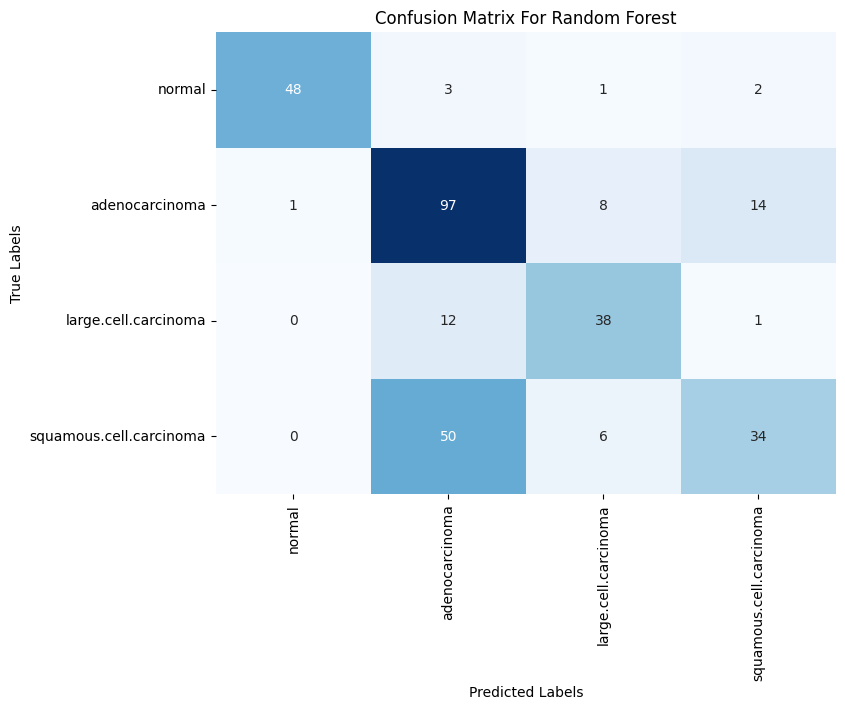

Classification Report:
                          precision    recall  f1-score   support

                 normal       0.98      0.89      0.93        54
         adenocarcinoma       0.60      0.81      0.69       120
   large.cell.carcinoma       0.72      0.75      0.73        51
squamous.cell.carcinoma       0.67      0.38      0.48        90

               accuracy                           0.69       315
              macro avg       0.74      0.71      0.71       315
           weighted avg       0.70      0.69      0.68       315



In [36]:
# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', cbar=False,
            xticklabels=[test_class_mappings[i] for i in range(len(test_class_mappings))],
            yticklabels=[test_class_mappings[i] for i in range(len(test_class_mappings))])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix For Random Forest')
plt.show()

class_report = classification_report(test_transformer_labels, rforest_predictions, target_names=test_class_mappings.values())

print("Classification Report:\n", class_report)

### Evaluate Classifiers Using Canny Edges

In [37]:
pca_models, train_features_pca = get_PCA([[img.flatten() for img in train_canny_edges]], n_components=200)

lda = LinearDiscriminantAnalysis()

lda.fit(train_features_pca[0], train_canny_labels)

X_lda = lda.transform(train_features_pca[0])

X_lda.shape

(614, 3)

In [38]:
X_train = X_lda
y_train = train_canny_labels

In [39]:
X_val_raw = np.array([img.flatten() for img in valid_canny_edges])
X_val_pca = pca_models[0].transform(X_val_raw)
X_val = lda.transform(X_val_pca)


y_val = valid_canny_labels

print(f"{X_val.shape=}")
print(f"{len(y_val)=}")

X_val.shape=(72, 3)
len(y_val)=72


In [40]:
X_test_raw = np.array([img.flatten() for img in test_canny_features])
X_test_pca = pca_models[0].transform(X_test_raw)
X_test = lda.transform(X_test_pca)


y_test = test_canny_labels

print(f"{X_test.shape=}")
print(f"{len(y_test)=}")

X_test.shape=(315, 3)
len(y_test)=315


In [41]:
param_grid = {
    'C': [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30, 100],
    'kernel': ['rbf', 'linear', 'sigmoid'],
    'gamma': [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30, 100]
}

svm_model = SVC()

grid_search = GridSearchCV(svm_model, param_grid, cv=5, scoring='f1_weighted')
# Fit the grid search to the data
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_svm = grid_search.best_estimator_

In [42]:
print("Best Hyperparameters:", best_params)

y_pred = best_svm.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
print("Best Model Accuracy:", accuracy)

Best Hyperparameters: {'C': 30, 'gamma': 0.01, 'kernel': 'linear'}
Best Model Accuracy: 0.6666666666666666


In [43]:
svm_predictions = best_svm.predict(X_test)
conf_matrix = confusion_matrix(y_test, svm_predictions)

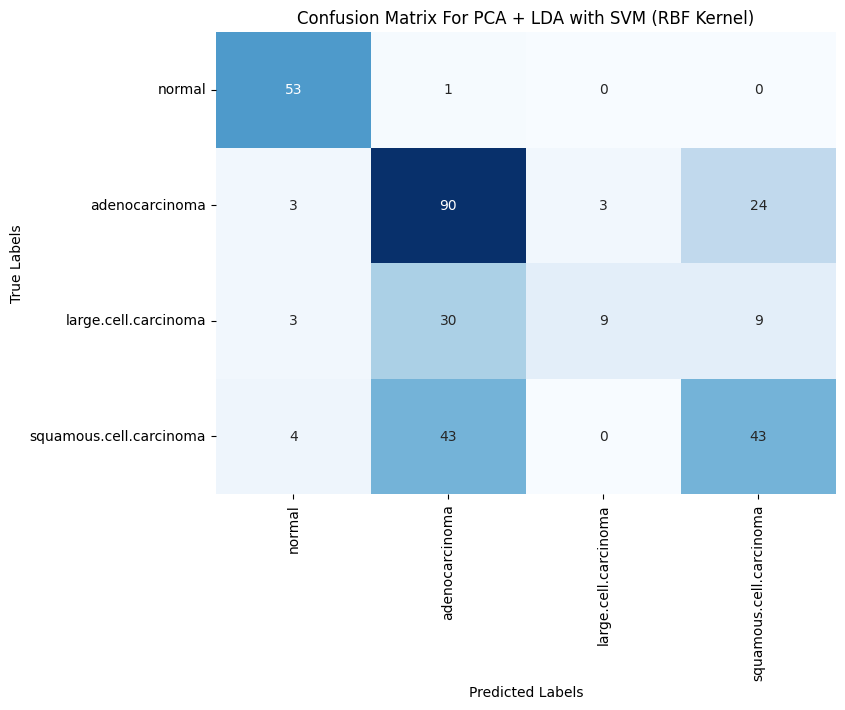

Classification Report:
                          precision    recall  f1-score   support

                 normal       0.84      0.98      0.91        54
         adenocarcinoma       0.55      0.75      0.63       120
   large.cell.carcinoma       0.75      0.18      0.29        51
squamous.cell.carcinoma       0.57      0.48      0.52        90

               accuracy                           0.62       315
              macro avg       0.68      0.60      0.59       315
           weighted avg       0.64      0.62      0.59       315



In [44]:
# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', cbar=False,
            xticklabels=[test_class_mappings[i] for i in range(len(test_class_mappings))],
            yticklabels=[test_class_mappings[i] for i in range(len(test_class_mappings))])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix For PCA + LDA with SVM (RBF Kernel)')
plt.show()

class_report = classification_report(test_transformer_labels, svm_predictions, target_names=test_class_mappings.values())

print("Classification Report:\n", class_report)

In [45]:
# Define a grid of hyperparameters to search
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_classifier = RandomForestClassifier(random_state=42)

# Create GridSearchCV instance
grid_search = GridSearchCV(rf_classifier, param_grid, cv=5, scoring='f1_weighted')

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_rforest = grid_search.best_estimator_

In [46]:
y_pred = best_rforest.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)

print("Best Hyperparameters:", best_params)
print("Best Model Accuracy:", accuracy)

Best Hyperparameters: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 50}
Best Model Accuracy: 0.6805555555555556


In [47]:
rforest_predictions = best_rforest.predict(X_test)
conf_matrix = confusion_matrix(y_test, rforest_predictions)

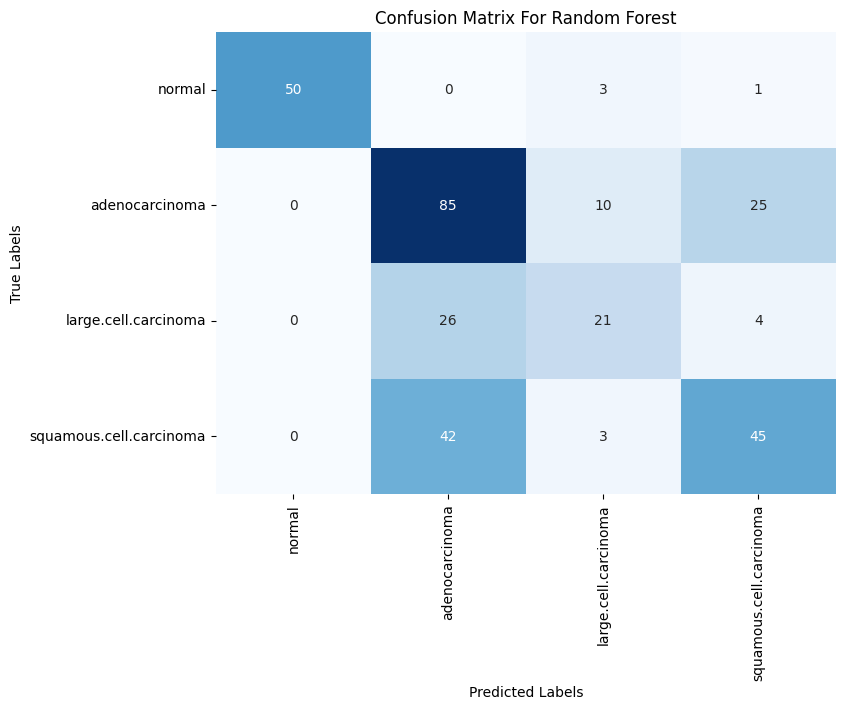

Classification Report:
                          precision    recall  f1-score   support

                 normal       1.00      0.93      0.96        54
         adenocarcinoma       0.56      0.71      0.62       120
   large.cell.carcinoma       0.57      0.41      0.48        51
squamous.cell.carcinoma       0.60      0.50      0.55        90

               accuracy                           0.64       315
              macro avg       0.68      0.64      0.65       315
           weighted avg       0.65      0.64      0.64       315



In [48]:
# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', cbar=False,
            xticklabels=[test_class_mappings[i] for i in range(len(test_class_mappings))],
            yticklabels=[test_class_mappings[i] for i in range(len(test_class_mappings))])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix For Random Forest')
plt.show()

class_report = classification_report(test_transformer_labels, rforest_predictions, target_names=test_class_mappings.values())

print("Classification Report:\n", class_report)

### Evaluate Classifiers Using Hounsfield Filtering

In [49]:
pca_models, train_features_pca = get_PCA([[img.flatten() for img in train_soft_tissue]], n_components=200)

lda = LinearDiscriminantAnalysis()

lda.fit(train_features_pca[0], train_soft_tissue_labels)

X_lda = lda.transform(train_features_pca[0])

X_lda.shape

(614, 3)

In [50]:
X_train = X_lda
y_train = train_soft_tissue_labels

In [51]:
X_val_raw = np.array([img.flatten() for img in valid_soft_tissue])
X_val_pca = pca_models[0].transform(X_val_raw)
X_val = lda.transform(X_val_pca)


y_val = valid_soft_tissue_labels

print(f"{X_val.shape=}")
print(f"{len(y_val)=}")

X_val.shape=(72, 3)
len(y_val)=72


In [52]:
X_test_raw = np.array([img.flatten() for img in test_soft_tissue])
X_test_pca = pca_models[0].transform(X_test_raw)
X_test = lda.transform(X_test_pca)


y_test = test_soft_tissue_labels

print(f"{X_test.shape=}")
print(f"{len(y_test)=}")

X_test.shape=(315, 3)
len(y_test)=315


In [53]:
param_grid = {
    'C': [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30, 100],
    'kernel': ['rbf', 'linear', 'sigmoid'],
    'gamma': [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30, 100]
}

svm_model = SVC()

grid_search = GridSearchCV(svm_model, param_grid, cv=5, scoring='f1_weighted')
# Fit the grid search to the data
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_svm = grid_search.best_estimator_

In [54]:
print("Best Hyperparameters:", best_params)

y_pred = best_svm.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
print("Best Model Accuracy:", accuracy)

Best Hyperparameters: {'C': 1, 'gamma': 0.03, 'kernel': 'rbf'}
Best Model Accuracy: 0.7361111111111112


In [55]:
svm_predictions = best_svm.predict(X_test)
conf_matrix = confusion_matrix(y_test, svm_predictions)

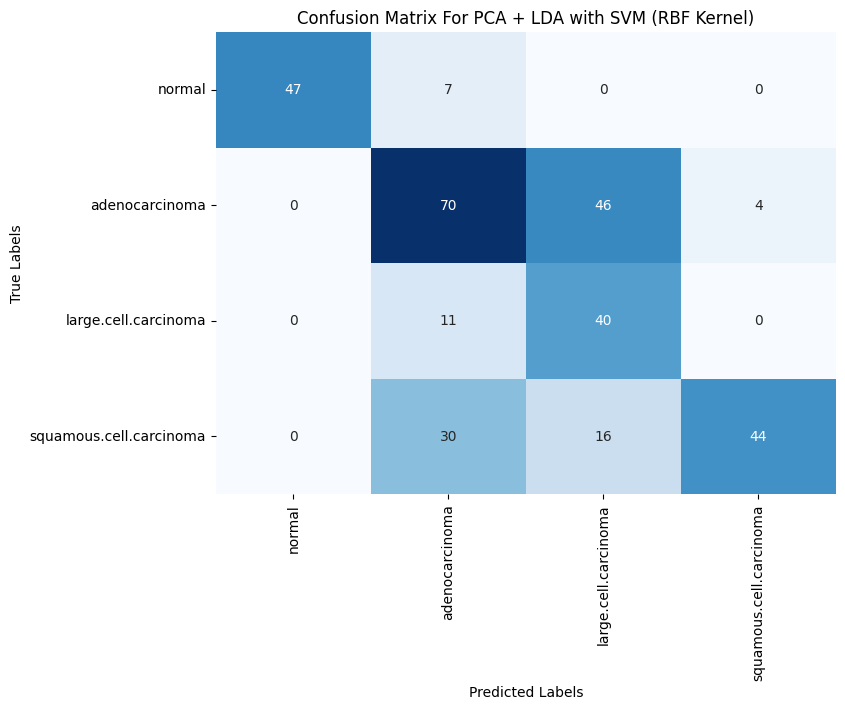

Classification Report:
                          precision    recall  f1-score   support

                 normal       1.00      0.87      0.93        54
         adenocarcinoma       0.59      0.58      0.59       120
   large.cell.carcinoma       0.39      0.78      0.52        51
squamous.cell.carcinoma       0.92      0.49      0.64        90

               accuracy                           0.64       315
              macro avg       0.73      0.68      0.67       315
           weighted avg       0.72      0.64      0.65       315



In [56]:
# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', cbar=False,
            xticklabels=[test_class_mappings[i] for i in range(len(test_class_mappings))],
            yticklabels=[test_class_mappings[i] for i in range(len(test_class_mappings))])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix For PCA + LDA with SVM (RBF Kernel)')
plt.show()

class_report = classification_report(test_transformer_labels, svm_predictions, target_names=test_class_mappings.values())

print("Classification Report:\n", class_report)

In [57]:
# Define a grid of hyperparameters to search
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_classifier = RandomForestClassifier(random_state=42)

# Create GridSearchCV instance
grid_search = GridSearchCV(rf_classifier, param_grid, cv=5, scoring='f1_weighted')

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_rforest = grid_search.best_estimator_

In [58]:
y_pred = best_rforest.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)

print("Best Hyperparameters:", best_params)
print("Best Model Accuracy:", accuracy)

Best Hyperparameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best Model Accuracy: 0.7222222222222222


In [59]:
rforest_predictions = best_rforest.predict(X_test)
conf_matrix = confusion_matrix(y_test, rforest_predictions)

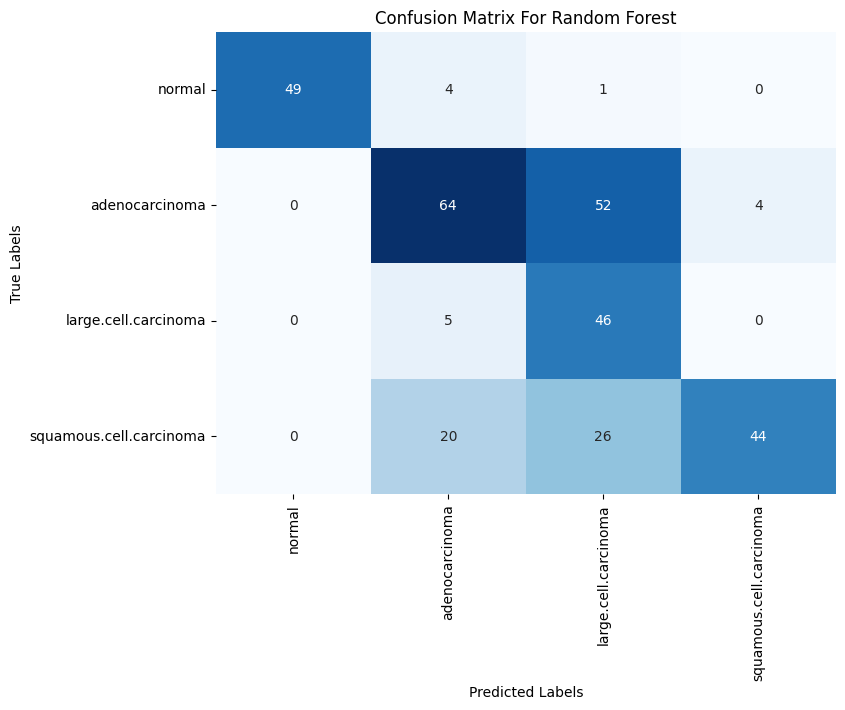

Classification Report:
                          precision    recall  f1-score   support

                 normal       1.00      0.91      0.95        54
         adenocarcinoma       0.69      0.53      0.60       120
   large.cell.carcinoma       0.37      0.90      0.52        51
squamous.cell.carcinoma       0.92      0.49      0.64        90

               accuracy                           0.64       315
              macro avg       0.74      0.71      0.68       315
           weighted avg       0.76      0.64      0.66       315



In [60]:
# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', cbar=False,
            xticklabels=[test_class_mappings[i] for i in range(len(test_class_mappings))],
            yticklabels=[test_class_mappings[i] for i in range(len(test_class_mappings))])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix For Random Forest')
plt.show()

class_report = classification_report(test_transformer_labels, rforest_predictions, target_names=test_class_mappings.values())

print("Classification Report:\n", class_report)

### Evaluate Classifiers Using Transformer Features

In [61]:
pca_models, train_features_pca = get_PCA([[img.flatten() for img in train_transformer_features]], n_components=200)

lda = LinearDiscriminantAnalysis()

lda.fit(train_features_pca[0], train_transformer_labels)

X_lda = lda.transform(train_features_pca[0])

X_lda.shape



(614, 3)

In [62]:
len(train_transformer_labels)

614

In [63]:
X_train = X_lda
y_train = train_transformer_labels

In [64]:
X_val_raw = np.array([img.flatten() for img in valid_transformer_features])
X_val_pca = pca_models[0].transform(X_val_raw)
X_val = lda.transform(X_val_pca)


y_val = valid_transformer_labels

print(f"{X_val.shape=}")
print(f"{len(y_val)=}")

X_val.shape=(72, 3)
len(y_val)=72


In [65]:
X_test_raw = np.array([img.flatten() for img in test_transformer_features])
X_test_pca = pca_models[0].transform(X_test_raw)
X_test = lda.transform(X_test_pca)


y_test = test_transformer_labels

print(f"{X_test.shape=}")
print(f"{len(y_test)=}")

X_test.shape=(315, 3)
len(y_test)=315


In [78]:
param_grid = {
    'C': [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30, 100],
    'kernel': ['rbf', 'linear', 'sigmoid'],
    'gamma': [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30, 100]
}

svm_model = SVC()

grid_search = GridSearchCV(svm_model, param_grid, cv=5, scoring='f1_weighted')
# Fit the grid search to the data
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_svm = grid_search.best_estimator_

In [79]:
print("Best Hyperparameters:", best_params)

y_pred = best_svm.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
print("Best Model Accuracy:", accuracy)

Best Hyperparameters: {'C': 0.03, 'gamma': 0.01, 'kernel': 'sigmoid'}
Best Model Accuracy: 0.875


In [80]:
svm_predictions = best_svm.predict(X_test)
conf_matrix = confusion_matrix(y_test, svm_predictions)


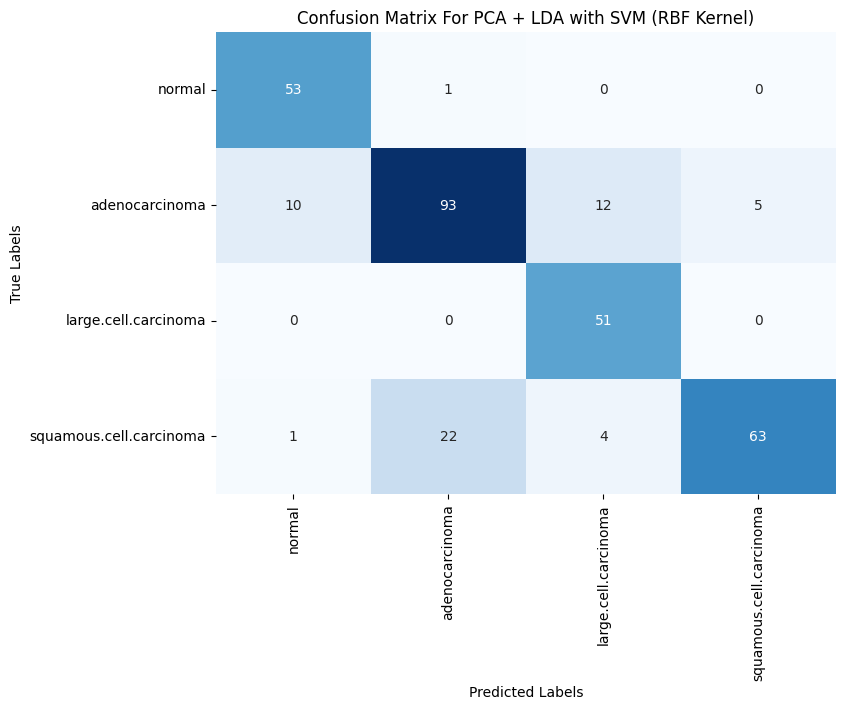

Classification Report:
                          precision    recall  f1-score   support

                 normal       0.83      0.98      0.90        54
         adenocarcinoma       0.80      0.78      0.79       120
   large.cell.carcinoma       0.76      1.00      0.86        51
squamous.cell.carcinoma       0.93      0.70      0.80        90

               accuracy                           0.83       315
              macro avg       0.83      0.86      0.84       315
           weighted avg       0.84      0.83      0.82       315



In [81]:
# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', cbar=False,
            xticklabels=[test_class_mappings[i] for i in range(len(test_class_mappings))],
            yticklabels=[test_class_mappings[i] for i in range(len(test_class_mappings))])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix For PCA + LDA with SVM (RBF Kernel)')
plt.show()

class_report = classification_report(test_transformer_labels, svm_predictions, target_names=test_class_mappings.values())

print("Classification Report:\n", class_report)

In [70]:
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

dtree = DecisionTreeClassifier()

# Create GridSearchCV instance
grid_search = GridSearchCV(dtree, param_grid, cv=5, scoring='f1_weighted')

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_dtree = grid_search.best_estimator_

In [71]:

y_pred = best_dtree.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)

print("Best Hyperparameters:", best_params)
print("Best Model Accuracy:", accuracy)

Best Hyperparameters: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10}
Best Model Accuracy: 0.8333333333333334


In [72]:
dtree_predictions = best_dtree.predict(X_test)
conf_matrix = confusion_matrix(y_test, dtree_predictions)



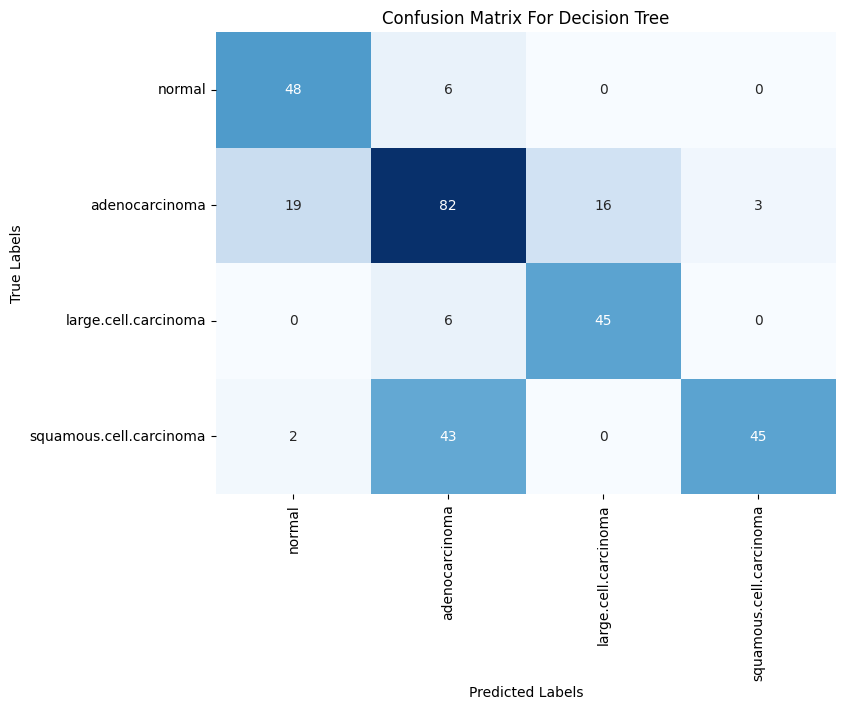

Classification Report:
                          precision    recall  f1-score   support

                 normal       0.70      0.89      0.78        54
         adenocarcinoma       0.60      0.68      0.64       120
   large.cell.carcinoma       0.74      0.88      0.80        51
squamous.cell.carcinoma       0.94      0.50      0.65        90

               accuracy                           0.70       315
              macro avg       0.74      0.74      0.72       315
           weighted avg       0.73      0.70      0.69       315



In [73]:
# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', cbar=False,
            xticklabels=[test_class_mappings[i] for i in range(len(test_class_mappings))],
            yticklabels=[test_class_mappings[i] for i in range(len(test_class_mappings))])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix For Decision Tree')
plt.show()

class_report = classification_report(test_transformer_labels, dtree_predictions, target_names=test_class_mappings.values())

print("Classification Report:\n", class_report)

In [74]:
# Define a grid of hyperparameters to search
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_classifier = RandomForestClassifier(random_state=42)

# Create GridSearchCV instance
grid_search = GridSearchCV(rf_classifier, param_grid, cv=5, scoring='f1_weighted')

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_rforest = grid_search.best_estimator_

In [75]:
y_pred = best_rforest.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)

print("Best Hyperparameters:", best_params)
print("Best Model Accuracy:", accuracy)

Best Hyperparameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Best Model Accuracy: 0.8611111111111112


In [76]:
rforest_predictions = best_rforest.predict(X_test)
conf_matrix = confusion_matrix(y_test, rforest_predictions)

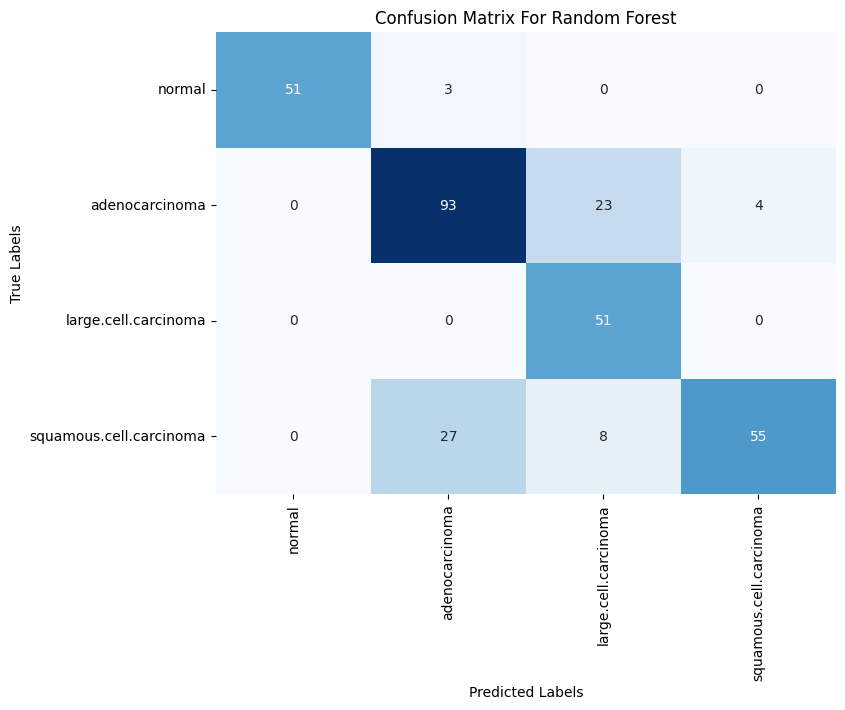

Classification Report:
                          precision    recall  f1-score   support

                 normal       0.70      0.89      0.78        54
         adenocarcinoma       0.60      0.68      0.64       120
   large.cell.carcinoma       0.74      0.88      0.80        51
squamous.cell.carcinoma       0.94      0.50      0.65        90

               accuracy                           0.70       315
              macro avg       0.74      0.74      0.72       315
           weighted avg       0.73      0.70      0.69       315



In [77]:


# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', cbar=False,
            xticklabels=[test_class_mappings[i] for i in range(len(test_class_mappings))],
            yticklabels=[test_class_mappings[i] for i in range(len(test_class_mappings))])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix For Random Forest')
plt.show()

class_report = classification_report(test_transformer_labels, dtree_predictions, target_names=test_class_mappings.values())

print("Classification Report:\n", class_report)